### EDA / Regression Viability
- Data Clean up
- Apply Inflation
- Log Transform
- Apply inflation to Gross - previously only done on budget
- Dummy Coding
- Linear Regression Models Pre-Post Log Transform
- Correlation Charts / Pair Plots

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import re
import cpi
from datetime import datetime

In [2]:
#bring data together
batch1 = pd.read_csv('/Users/jennihawk/Desktop/Thriller Project/Movie_Linear_Regression/thriller_csv_files/thrillers_1_to_350_year_budget.csv')
batch2 = pd.read_csv('/Users/jennihawk/Desktop/Thriller Project/Movie_Linear_Regression/thriller_csv_files/thrillers_351_700rows.csv')
batch3 = pd.read_csv('/Users/jennihawk/Desktop/Thriller Project/Movie_Linear_Regression/thriller_csv_files/thrillers_751_1150rows.csv')

all_movies = [batch1, batch2, batch3]

movie_df = pd.concat(all_movies)

In [3]:
movie_df.reset_index(drop=True, inplace=True)

In [4]:
#movie_df

#### Replace current budget column with new, updated column values

In [5]:
all_budget = pd.read_csv('/Users/jennihawk/Desktop/Thriller Project/Movie_Linear_Regression/thriller_csv_files/all_data_budgetcol_only.csv')

In [6]:
all_budget.head()

,Title,Budget
0,The Dark Knight,185000000.0
1,The Hunger Games: Catching Fire,130000000.0
2,The Hunger Games,78000000.0
3,Jurassic Park,63000000.0
4,Furious 7,190000000.0


In [7]:
movie_df.loc[:, ['Budget']] = all_budget['Budget']

In [8]:
#27 missing budget values
#movie_df.info()

In [9]:
# shows rows that have null values
null_data = movie_df[movie_df.isnull().any(axis=1)]
#null_data

In [10]:
#sum of rows with at least one missing data
total_miss = movie_df.isnull().any(axis=1).sum()
total_miss

27

In [11]:
#drop th 27 nulls
movie_df.dropna(subset=['Budget'], inplace=True)

In [12]:
# drop outlier The Curse of Frankenstein 1957
movie_df.drop(index = 1084, inplace = True)

In [13]:
#find original Jaws in 'Title' use 'contains' to find substring in column
find_jaws = movie_df.loc[movie_df['Title'].str.contains("Jaws", case=False)]
#find_jaws

In [14]:
# drop outlier Jaws 1975 - Jaws is a complete unique phenomenon that would distort charts
movie_df.drop(index = 14, inplace = True)

#### Clean up

In [15]:
#remove any leading/trailing in column titles
movie_df.columns = movie_df.columns.map(str.strip)
#movie_df

In [16]:
# Duration cleanup + change to float
movie_df['Duration'] = movie_df['Duration'].str.replace('min', '').astype(float)

In [17]:
movie_df['Budget'] = movie_df['Budget'].astype(float)

In [18]:
pd.set_option('display.max_rows', None)

In [19]:
# Cast year as string to remove extra chars in front of some columns year
movie_df['Year'] = movie_df['Year'].astype(str)

In [20]:
movie_df['Duration'] = movie_df['Duration'].astype(int)

In [21]:
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534.86,Christopher Nolan,Christian Bale,185000000.0,2008
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424.67,Francis Lawrence,Jennifer Lawrence,130000000.0,2013
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408.01,Gary Ross,Jennifer Lawrence,78000000.0,2012
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402.45,Steven Spielberg,Sam Neill,63000000.0,1993
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353.01,James Wan,Vin Diesel,190000000.0,2015


#### Clean up extra chars in year 

In [22]:
# remove extra chars in year column
def my_function(x):
    return x[-4:]
#saves over the column
movie_df['Year'] = movie_df['Year'].map(my_function)       

In [23]:
movie_df

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534.86,Christopher Nolan,Christian Bale,185000000.0,2008
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424.67,Francis Lawrence,Jennifer Lawrence,130000000.0,2013
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408.01,Gary Ross,Jennifer Lawrence,78000000.0,2012
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402.45,Steven Spielberg,Sam Neill,63000000.0,1993
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353.01,James Wan,Vin Diesel,190000000.0,2015
5,The Hunger Games: Mockingjay - Part 1,123,"Action, Adventure, Sci-Fi",PG-13,337.14,Francis Lawrence,Jennifer Lawrence,125000000.0,2014
6,Joker,122,"Crime, Drama, Thriller",R,335.45,Todd Phillips,Joaquin Phoenix,55000000.0,2019
7,Skyfall,143,"Action, Adventure, Thriller",PG-13,304.36,Sam Mendes,Daniel Craig,200000000.0,2012
8,The Twilight Saga: Eclipse,124,"Action, Adventure, Drama",PG-13,300.53,David Slade,Kristen Stewart,68000000.0,2010
9,The Sixth Sense,107,"Drama, Mystery, Thriller",PG-13,293.51,M. Night Shyamalan,Bruce Willis,40000000.0,1999


### Inflation work
https://pypi.org/project/cpi/

In [24]:
movie_df['Year']=pd.to_datetime(movie_df['Year'], format='%Y')

In [25]:
movie_df['Year'] = movie_df['Year'].dt.year

In [26]:
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534.86,Christopher Nolan,Christian Bale,185000000.0,2008
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424.67,Francis Lawrence,Jennifer Lawrence,130000000.0,2013
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408.01,Gary Ross,Jennifer Lawrence,78000000.0,2012
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402.45,Steven Spielberg,Sam Neill,63000000.0,1993
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353.01,James Wan,Vin Diesel,190000000.0,2015


In [27]:
movie_df['Budget_Adjust'] = movie_df.apply(lambda x: cpi.inflate(x.Budget, x.Year), axis=1)

In [28]:
movie_df['Budget_Adjust'] = movie_df['Budget_Adjust'].round(decimals = 1)

In [29]:
movie_df['Gross_Adjust'] = movie_df.apply(lambda x: cpi.inflate(x.Gross, x.Year), axis=1)

In [30]:
movie_df['Gross_Adjust'] = movie_df['Gross_Adjust'].round(decimals = 2)

In [31]:
movie_df

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year,Budget_Adjust,Gross_Adjust
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534.86,Christopher Nolan,Christian Bale,185000000.0,2008,232832101.7,673.15
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424.67,Francis Lawrence,Jennifer Lawrence,130000000.0,2013,151212884.8,493.97
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408.01,Gary Ross,Jennifer Lawrence,78000000.0,2012,92056674.0,481.54
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402.45,Steven Spielberg,Sam Neill,63000000.0,1993,118139169.6,754.68
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353.01,James Wan,Vin Diesel,190000000.0,2015,217217752.3,403.58
5,The Hunger Games: Mockingjay - Part 1,123,"Action, Adventure, Sci-Fi",PG-13,337.14,Francis Lawrence,Jennifer Lawrence,125000000.0,2014,143076042.5,385.89
6,Joker,122,"Crime, Drama, Thriller",R,335.45,Todd Phillips,Joaquin Phoenix,55000000.0,2019,58294316.2,355.54
7,Skyfall,143,"Action, Adventure, Thriller",PG-13,304.36,Sam Mendes,Daniel Craig,200000000.0,2012,236042753.7,359.21
8,The Twilight Saga: Eclipse,124,"Action, Adventure, Drama",PG-13,300.53,David Slade,Kristen Stewart,68000000.0,2010,84501045.6,373.46
9,The Sixth Sense,107,"Drama, Mystery, Thriller",PG-13,293.51,M. Night Shyamalan,Bruce Willis,40000000.0,1999,65058823.5,477.39


In [32]:
#spot check 
# test = cpi.inflate(185000000, 2008, to=2021)
# test

#### Dummy Coding - Genre

In [33]:
#movie_df['Genre'].value_counts()

In [34]:
#Genre Coding
#finds every instance of word 1,0 one-hot-encode everywhere the word is
#pandas method is the parenthesis after'where() searches column for word
movie_df['Action'] = np.where(movie_df.Genre.str.contains('action', case = False, na = False), 1,0)
movie_df['Adventure'] = np.where(movie_df.Genre.str.contains('adventure', case = False, na = False), 1,0)
movie_df['Sci-Fi'] = np.where(movie_df.Genre.str.contains('sci-fi', case = False, na = False), 1,0)
movie_df['Crime'] = np.where(movie_df.Genre.str.contains('crime', case = False, na = False), 1,0)
movie_df['Drama'] = np.where(movie_df.Genre.str.contains('drama', case = False, na = False), 1,0)
movie_df['Horror'] = np.where(movie_df.Genre.str.contains('horror', case = False, na = False), 1,0)
movie_df['Mystery'] = np.where(movie_df.Genre.str.contains('mystery', case = False, na = False), 1,0)
movie_df['Comedy'] = np.where(movie_df.Genre.str.contains('comedy', case = False, na = False), 1,0)
movie_df['History'] = np.where(movie_df.Genre.str.contains('history', case = False, na = False), 1,0)
movie_df['Biography'] = np.where(movie_df.Genre.str.contains('biography', case = False, na = False), 1,0)
movie_df['Fantasy'] = np.where(movie_df.Genre.str.contains('fantasy', case = False, na = False), 1,0)
movie_df['Romance'] = np.where(movie_df.Genre.str.contains('romance', case = False, na = False), 1,0)

In [35]:
#dummy coding of action combined with adventure because they're highly correlated with each other
movie_df['Action_Adv'] = np.where(movie_df.Genre.str.contains('action|adventure', case = False, na = False), 1,0)
movie_df['Adv_Scifi'] = np.where(movie_df.Genre.str.contains('adventure|sci-fi', case = False, na = False), 1,0)

In [36]:
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year,Budget_Adjust,...,Drama,Horror,Mystery,Comedy,History,Biography,Fantasy,Romance,Action_Adv,Adv_Scifi
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534.86,Christopher Nolan,Christian Bale,185000000.0,2008,232832101.7,...,1,0,0,0,0,0,0,0,1,0
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424.67,Francis Lawrence,Jennifer Lawrence,130000000.0,2013,151212884.8,...,1,0,0,0,0,0,0,0,1,1
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408.01,Gary Ross,Jennifer Lawrence,78000000.0,2012,92056674.0,...,0,0,0,0,0,0,0,0,1,1
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402.45,Steven Spielberg,Sam Neill,63000000.0,1993,118139169.6,...,0,0,0,0,0,0,0,0,1,1
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353.01,James Wan,Vin Diesel,190000000.0,2015,217217752.3,...,0,0,0,0,0,0,0,0,1,0


#### Rating Dummy Coding

In [37]:
#movie_df['Rating'].value_counts()

In [38]:
movie_df['R'] = np.where(movie_df.Rating.str.contains('R', case = False, na = False), 1,0)
movie_df['PG-13'] = np.where(movie_df.Rating.str.contains('PG-13', case = False, na = False), 1,0)
#code below 'PG' is also counting 'PG-13' need different solution
#movie_df['PG'] = np.where(movie_df.Rating.str.contains('PG', case = False, na = False), 1,0)

In [39]:
#check to see if given columns are both being dummy coded as 1 should not be
#movie_df[(movie_df['PG']==1) & (movie_df['PG-13']==1)]

In [40]:
movie_df.columns

Index(['Title', 'Duration', 'Genre', 'Rating', 'Gross', 'Director', 'Lead',
       'Budget', 'Year', 'Budget_Adjust', 'Gross_Adjust', 'Action',
       'Adventure', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy',
       'History', 'Biography', 'Fantasy', 'Romance', 'Action_Adv', 'Adv_Scifi',
       'R', 'PG-13'],
      dtype='object')

#### csv of pre-log data for train/testing

In [57]:
#features_tst = movie_df[['Budget_Adjust', 'Gross_Adjust', 'Action_Adv', 'Adv_Scifi', 'PG-13', 'Duration']]
#features_tst.to_csv('features_tst.csv', index=False)

#### Linear Regression Code - Before Log Transform - All Features 

In [45]:
movie_df.columns

Index(['Title', 'Duration', 'Genre', 'Rating', 'Gross', 'Director', 'Lead',
       'Budget', 'Year', 'Budget_Adjust', 'Gross_Adjust', 'Action',
       'Adventure', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy',
       'History', 'Biography', 'Fantasy', 'Romance', 'Action_Adv', 'Adv_Scifi',
       'R', 'PG-13'],
      dtype='object')

In [46]:
# drop target column and others not needed
x = movie_df.drop(columns = ['Gross', 'Gross_Adjust', 'Title', 'Budget', 'Genre', 'Rating','Director', 'Lead', 'Year', 'Action', 'Adventure'])
x = sm.add_constant(x)

# target
y = movie_df['Gross_Adjust']
model = sm.OLS(y,x, data = movie_df)
movie_model = model.fit()
movie_model.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Gross_Adjust   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     27.52
Date:                Sun, 10 Jul 2022   Prob (F-statistic):           6.14e-69
Time:                        12:49:05   Log-Likelihood:                -6170.0
No. Observations:                1071   AIC:                         1.237e+04
Df Residuals:                    1054   BIC:                         1.246e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            46.9455     23.277      2.017      0.044       1.270      92.621
Duration          1.2051      0.182      6.631      0.000       0.848       1.562
Budget_Adjust  5.351e-07   6.11e-08      8.760      0.000    4.15e-07    6.55e-07
Sci-Fi            2.4452      8.902      0.275      0.784     -15.022      19.912
Crime           -12.1249      6.113     -1.983      0.048     -24.120      -0.130
Drama           -11.4540      5.864     -1.953      0.051     -22.961       0.053
Horror           -6.2947      8.237     -0.764      0.445     -22.458       9.869
Mystery         -11.2056      6.934     -1.616      0.106     -24.812       2.401
Comedy          -12.3805      8.429     -1.469      0.142     -28.919       4.158
History         -51.7939     17.466     -2.965      0.003     -86.067     -17.521
Biography       -11.8580     17.824     -0.665      0.506     -46.832      23.116
Fantasy         -15.8803     11.573     -1.372      0.170     -38.589       6.829
Romance         -18.1144     12.199     -1.485      0.138     -42.051       5.823
Action_Adv       -2.1061      6.882     -0.306      0.760     -15.610      11.397
Adv_Scifi       -20.6324      7.907     -2.610      0.009     -36.147      -5.118
R              -104.5146     10.348    -10.100      0.000    -124.820     -84.209
PG-13           -87.5362     10.488     -8.346      0.000    -108.117     -66.956
==============================================================================
Omnibus:                      599.780   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6260.345
Skew:                           2.387   Prob(JB):                         0.00
Kurtosis:                      13.840   Cond. No.                     8.71e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Log Transform
- Applied to both Gross and Budget because both had exponential increase.

In [47]:
movie_df['Log_Budget_Adj'] = np.log(movie_df['Budget_Adjust'])
#movie_df

In [48]:
movie_df['Log_Gross'] = np.log(movie_df['Gross_Adjust'])
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year,Budget_Adjust,...,History,Biography,Fantasy,Romance,Action_Adv,Adv_Scifi,R,PG-13,Log_Budget_Adj,Log_Gross
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534.86,Christopher Nolan,Christian Bale,185000000.0,2008,232832101.7,...,0,0,0,0,1,0,0,1,19.265828,6.511968
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424.67,Francis Lawrence,Jennifer Lawrence,130000000.0,2013,151212884.8,...,0,0,0,0,1,1,0,1,18.834199,6.202475
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408.01,Gary Ross,Jennifer Lawrence,78000000.0,2012,92056674.0,...,0,0,0,0,1,1,0,1,18.337915,6.176989
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402.45,Steven Spielberg,Sam Neill,63000000.0,1993,118139169.6,...,0,0,0,0,1,1,0,1,18.587374,6.626294
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353.01,James Wan,Vin Diesel,190000000.0,2015,217217752.3,...,0,0,0,0,1,0,0,1,19.196411,6.000375


In [58]:
movie_df.columns

Index(['Title', 'Duration', 'Genre', 'Rating', 'Gross', 'Director', 'Lead',
       'Budget', 'Year', 'Budget_Adjust', 'Gross_Adjust', 'Action',
       'Adventure', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy',
       'History', 'Biography', 'Fantasy', 'Romance', 'Action_Adv', 'Adv_Scifi',
       'R', 'PG-13', 'Log_Budget_Adj', 'Log_Gross'],
      dtype='object')

#### csv of log transform for feature train/validate/test

In [61]:
# log_tst = movie_df[['Log_Budget_Adj','Log_Gross', 'Action_Adv', 'Adv_Scifi', 'PG-13', 'Duration']]
# log_tst.to_csv('log_tst.csv', index=False)

#### Linear Regression Log Transform -  All Features  
- Review impact of log transform on model

In [49]:
# drop target column and others not needed
x = movie_df.drop(columns = ['Gross', 'Gross_Adjust', 'Title', 'Budget', 'Genre', 'Rating','Director', 'Lead', 'Year', 'Action', 'Adventure'])
x = sm.add_constant(x)

# target
y = movie_df['Gross_Adjust']
model = sm.OLS(y,x, data = movie_df)
movie_model = model.fit()
movie_model.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Gross_Adjust   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     264.5
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:49:06   Log-Likelihood:                -5441.5
No. Observations:                1071   AIC:                         1.092e+04
Df Residuals:                    1052   BIC:                         1.102e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -210.8550     45.444     -4.640      0.000    -300.026    -121.684
Duration           0.2433      0.094      2.579      0.010       0.058       0.428
Budget_Adjust   9.147e-08   5.06e-08      1.809      0.071   -7.76e-09    1.91e-07
Sci-Fi             4.5326      4.521      1.003      0.316      -4.339      13.404
Crime              0.3484      3.116      0.112      0.911      -5.766       6.463
Drama              5.3144      2.990      1.777      0.076      -0.552      11.181
Horror             1.8089      4.297      0.421      0.674      -6.622      10.240
Mystery           -4.2275      3.519     -1.201      0.230     -11.133       2.678
Comedy            -2.8472      4.282     -0.665      0.506     -11.249       5.555
History           -9.1354      8.890     -1.028      0.304     -26.579       8.308
Biography          1.7398      9.050      0.192      0.848     -16.018      19.498
Fantasy            4.7211      5.901      0.800      0.424      -6.858      16.300
Romance           -6.5830      6.189     -1.064      0.288     -18.728       5.562
Action_Adv         9.6138      3.498      2.748      0.006       2.750      16.478
Adv_Scifi         -5.6812      4.018     -1.414      0.158     -13.565       2.203
R                -25.2440      5.455     -4.628      0.000     -35.947     -14.541
PG-13            -15.0263      5.500     -2.732      0.006     -25.819      -4.234
Log_Budget_Adj   -10.1328      2.617     -3.872      0.000     -15.267      -4.998
Log_Gross        109.1487      1.991     54.824      0.000     105.242     113.055
==============================================================================
Omnibus:                      891.406   Durbin-Watson:                   1.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28839.216
Skew:                           3.640   Prob(JB):                         0.00
Kurtosis:                      27.357   Cond. No.                     3.15e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Investigate if findings for feature scores were impacted with transform
- Answer is no. Did not change the findings.

#### Regression Viability Charts: With Log Transform All Features (action/adventure) combined

In [50]:
first_set = movie_df[['Log_Gross','Log_Budget_Adj','Duration','Action_Adv', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy', 'History', 'Biography', 'Fantasy','R', 'PG-13']].copy()
first_set.head()

,Log_Gross,Log_Budget_Adj,Duration,Action_Adv,Sci-Fi,Crime,Drama,Horror,Mystery,Comedy,History,Biography,Fantasy,R,PG-13
0,6.511968,19.265828,152,1,0,1,1,0,0,0,0,0,0,0,1
1,6.202475,18.834199,146,1,0,0,1,0,0,0,0,0,0,0,1
2,6.176989,18.337915,142,1,1,0,0,0,0,0,0,0,0,0,1
3,6.626294,18.587374,127,1,1,0,0,0,0,0,0,0,0,0,1
4,6.000375,19.196411,137,1,0,1,0,0,0,0,0,0,0,0,1


In [51]:
# pandas correlation chart to use to get heatmap
get_corr = first_set.corr()
get_corr

,Log_Gross,Log_Budget_Adj,Duration,Action_Adv,Sci-Fi,Crime,Drama,Horror,Mystery,Comedy,History,Biography,Fantasy,R,PG-13
Log_Gross,1.000000,0.393183,0.358984,0.141604,0.063937,-0.105451,-0.087280,-0.183515,-0.045363,-0.005126,-0.021849,-0.040020,-0.055391,-0.219893,0.093715
Log_Budget_Adj,0.393183,1.000000,0.438634,0.367559,0.164922,-0.005264,-0.045689,-0.427562,-0.181923,0.025080,0.028273,-0.067033,0.010584,-0.243896,0.239264
Duration,0.358984,0.438634,1.000000,0.046251,-0.006528,0.016816,0.243396,-0.322355,-0.015308,-0.123425,0.185919,0.084825,-0.087790,-0.015303,-0.021667
Action_Adv,0.141604,0.367559,0.046251,1.000000,0.119226,0.015811,-0.296174,-0.367631,-0.448013,0.049850,-0.071451,-0.113378,-0.016528,-0.142655,0.102751
Sci-Fi,0.063937,0.164922,-0.006528,0.119226,1.000000,-0.275539,-0.153036,0.072367,-0.074056,-0.118992,-0.059554,-0.056852,-0.089890,-0.161486,0.173477
Crime,-0.105451,-0.005264,0.016816,0.015811,-0.275539,1.000000,0.151320,-0.324736,-0.095249,0.145041,-0.095548,0.020995,-0.148106,0.278144,-0.206014
Drama,-0.087280,-0.045689,0.243396,-0.296174,-0.153036,0.151320,1.000000,-0.212905,0.010479,-0.179511,0.173033,0.110655,-0.067195,0.152878,-0.114975
Horror,-0.183515,-0.427562,-0.322355,-0.367631,0.072367,-0.324736,-0.212905,1.000000,0.226499,-0.111003,-0.069237,-0.066095,0.101240,0.071496,-0.032671
Mystery,-0.045363,-0.181923,-0.015308,-0.448013,-0.074056,-0.095249,0.010479,0.226499,1.000000,-0.114609,-0.076184,-0.072727,0.025154,-0.000426,0.011349
Comedy,-0.005126,0.025080,-0.123425,0.049850,-0.118992,0.145041,-0.179511,-0.111003,-0.114609,1.000000,-0.050374,-0.048088,-0.061650,-0.064970,0.006616


<AxesSubplot:>

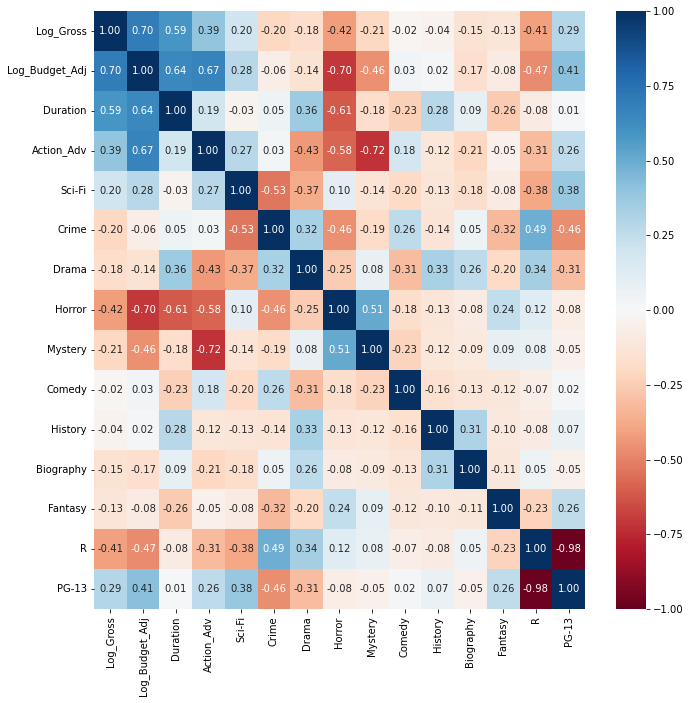

In [52]:
# seaborn correlation heatmap
fig, ax = plt.subplots(figsize=(11,11))
#center set to white - judge positive and negative correlation on equal footing 
#vmin/vmax specifices what values will start and end color map
#fmt tells seaborn how many decimal places we want
sns.heatmap(get_corr.corr(), cmap='RdBu', center=0, vmin=-1, vmax=1, annot=True, fmt = '.2f')

In [53]:
sns.set_style('darkgrid')

https://stackoverflow.com/questions/53717543/reduce-number-of-plots-in-sns-pairplot

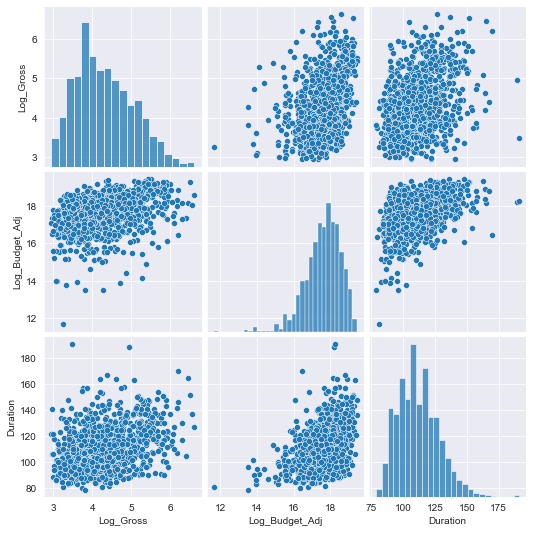

In [54]:
sns.pairplot(first_set, vars = ['Log_Gross', 'Log_Budget_Adj', 'Duration'])

<AxesSubplot:xlabel='Log_Budget_Adj', ylabel='Log_Gross'>

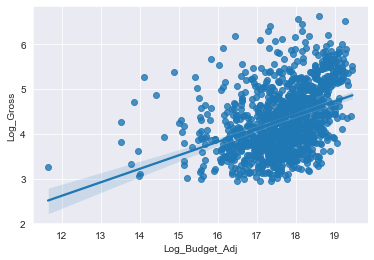

In [55]:
plt.ticklabel_format(style='plain')
sns.set(rc={"figure.figsize":(12, 8)}) #width, height
sns.regplot(x='Log_Budget_Adj', y='Log_Gross', data=first_set)